In [194]:
# 1. Need to Get the Airport Location NY_Airport_Data [Done]

import csv
import pandas as pd
from lat_lon_parser import parse
import folium as fd
from IPython.display import HTML, display

airport_df = pd.read_csv(r'NY_Airport_Data.csv')
airport_df = airport_df[['ref_point_lat','ref_point_lon','objectid','fac_type','loc_id','region_code','state_name','county','fac_name']]
airport_df = airport_df[airport_df.fac_type == 'AIRPORT']
airport_df = airport_df.reset_index(drop=True)


def calculate_lat(row):
    val = parse(row['ref_point_lat'])
    return val
def calculate_lon(row):
    val = parse(row['ref_point_lon'])
    return val

airport_df['lat'] = (airport_df.apply(calculate_lat, axis=1)).round(2)
airport_df['lon'] = (airport_df.apply(calculate_lon, axis=1)).round(3)
airport_df = airport_df.reset_index(drop=True)
# v = parse("41-13-51.7000N")



In [195]:
import xarray as xr

filename_wind_nc4 = "2021_JAN1_NY_Wind"
netcdf_file_name = filename_wind_nc4 + '.nc4'
csv_file_out = filename_wind_nc4 + '.csv'

ds = xr.open_dataset(netcdf_file_name)
df = ds.to_dataframe()
print(df.describe())
df.to_csv(csv_file_out)

import pandas as pd
import numpy as np

windspeed_df = pd.read_csv(csv_file_out)
windspeed_df = pd.DataFrame(windspeed_df)

windspeed_df = windspeed_df[['lat','lon','U2M','V2M','time']]
windspeed_df['lat'] = windspeed_df['lat'].round(2)
windspeed_df['lon'] = windspeed_df['lon'].round(2)
windspeed_df['date'] = pd.to_datetime(windspeed_df['time']).dt.date

csv_file_out_processed = filename_wind_nc4 + "_final.csv"

windspeed_df.to_csv(csv_file_out_processed)


# Compute the wind speed for the NewYork State on daily basis.....

import pandas as pd
import numpy as np

windspeed_df = pd.read_csv(csv_file_out_processed)
windspeed_df = pd.DataFrame(windspeed_df)

# print(windspeed_df)
lon = windspeed_df['lon']
lat = windspeed_df['lat']
date = windspeed_df['date']

# 2-meter eastward wind m/s
U2M = windspeed_df['U2M']
# 2-meter northward wind m/s
V2M = windspeed_df['V2M']

# Replace _FillValues with NaNs:df.replace(r'^\s*$', np.nan, regex=True)
U2M_nans = U2M[:].replace(r'^\s*$', np.nan, regex=True)
V2M_nans = V2M[:].replace(r'^\s*$', np.nan, regex=True)


# Calculate wind speed:

ws = np.sqrt(U2M_nans**2+V2M_nans**2)
list_s = [lat, lon, date]

new_df = pd.concat(list_s, axis=1)
new_df['avg_windspeed'] = ws
print(new_df.columns)
new_df = pd.DataFrame(new_df.groupby(['lat','lon']).mean()).reset_index()
new_df['date'] = date
new_df

               U2M          T2M          V2M         QV2M
count  3360.000000  3360.000000  3360.000000  3360.000000
mean     -0.325037   270.339172    -0.048653     0.002686
std       1.262722     3.522854     1.018545     0.000525
min      -7.613532   260.756714    -7.840244     0.001472
25%      -0.488761   267.633492    -0.277007     0.002314
50%      -0.137993   270.289673    -0.004459     0.002641
75%       0.212844   272.850693     0.337466     0.002993
max       4.408467   282.051697     3.237480     0.005405
Index(['lat', 'lon', 'date', 'avg_windspeed'], dtype='object')


,lat,lon,avg_windspeed,date
0,40.5,-80.00,0.551219,2021-01-01
1,40.5,-79.38,0.535491,2021-01-01
2,40.5,-78.75,0.522998,2021-01-01
3,40.5,-78.12,0.410040,2021-01-01
4,40.5,-77.50,0.336733,2021-01-01
...,...,...,...,...
135,45.0,-74.38,0.669200,2021-01-01
136,45.0,-73.75,0.531565,2021-01-01
137,45.0,-73.12,0.553786,2021-01-01
138,45.0,-72.50,0.540473,2021-01-01


In [196]:
def generate_blocks(ws_df):
    _blocks = {
        'lower_left_lat': [],
        'lower_left_lon': [],
        'upper_right_lat': [],
        'upper_right_lon': [],
        'avg_speed': [],
        'date': [],

    }
    # retrieve lat lon list
    lat_list = sorted(set(ws_df['lat'].tolist()))
    lon_list = sorted(set(ws_df['lon'].tolist()))
    date_list = (set(ws_df['date'].tolist()))
    # for loop to generate all blocks
    # todo change 'avg windspeed' to wind speed
    speed = 0
    for x in range(len(lat_list) - 1):
        for y in range(len(lon_list) - 1):
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]

            speed = speed / 4
            _blocks['lower_left_lat'].append(lat_list[x])
            _blocks['upper_right_lat'].append(lat_list[x + 1])
            _blocks['lower_left_lon'].append(lon_list[y])
            _blocks['upper_right_lon'].append(lon_list[y + 1])
            _blocks['avg_speed'].append(speed)
            _blocks['date'].append(ws_df.loc[x,'date'])
            speed = 0
        
        
    blocks = pd.DataFrame(_blocks)
    return blocks

blocks = generate_blocks(new_df)
blocks

,lower_left_lat,lower_left_lon,upper_right_lat,upper_right_lon,avg_speed,date
0,40.5,-80.00,41.0,-79.38,0.558530,2021-01-01
1,40.5,-79.38,41.0,-78.75,0.556753,2021-01-01
2,40.5,-78.75,41.0,-78.12,0.498158,2021-01-01
3,40.5,-78.12,41.0,-77.50,0.418036,2021-01-01
4,40.5,-77.50,41.0,-76.88,0.415482,2021-01-01
...,...,...,...,...,...,...
112,44.5,-75.00,45.0,-74.38,0.524296,2021-01-01
113,44.5,-74.38,45.0,-73.75,0.502647,2021-01-01
114,44.5,-73.75,45.0,-73.12,0.495066,2021-01-01
115,44.5,-73.12,45.0,-72.50,0.496558,2021-01-01


In [197]:
airport_df = airport_df.sort_values('lat')

locations = airport_df[['lat','lon']]
wind_locations = new_df[['lat','lon']]
locations_list = locations.values.tolist()
wind_list = wind_locations.values.tolist()

map = fd.Map(location=[43, -75], zoom_start=12)

for point in range(0, len(locations_list)):
    # print(locations_list[point], point)
    fd.Marker(locations_list[point], popup=airport_df['fac_name'][point]).add_to(map)


for point in range(0, len(wind_list)):
    # print(wind_list[point], point)
    fd.Marker(wind_list[point], popup=new_df['avg_windspeed'][point], icon=fd.Icon(color='red')).add_to(map)

map.save('map.html')



In [174]:
# 3. Need to get the precipitation data and calulate the avg [Need to collect]

In [198]:
# Merge the data sets [Issues encountered]
def calculate_airport_avg_windspeed(airport_df):

    for row_id, row in airport_df.iterrows():
        lat_val = row.lat
        lon_val = row.lon
        filter1_a = lat_val >= blocks['lower_left_lat']
        filter1_b = lat_val <= blocks['upper_right_lat']
        filter2_a = lon_val >= blocks['lower_left_lon']
        filter2_b = lon_val <= blocks['upper_right_lon']
        calc_time = blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].date.tolist()[0]
        calc_speed_temp = round(blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].avg_speed.tolist()[0], 3)
        (airport_df.at[row_id, 'avg_calculated_windspeed']) = calc_speed_temp
        (airport_df.at[row_id, 'date']) = calc_time
    
    return airport_df
    
final_dataset_with_speed_and_airport = calculate_airport_avg_windspeed(airport_df)
final_dataset_with_speed_and_airport = final_dataset_with_speed_and_airport.reset_index(drop=True)


In [199]:
final_dataset_with_speed_and_airport = final_dataset_with_speed_and_airport.sort_values('lat')

locations = final_dataset_with_speed_and_airport[['lat','lon']]
wind_locations = new_df[['lat','lon']]
locations_list = locations.values.tolist()
wind_list = wind_locations.values.tolist()

map = fd.Map(location=[43, -75], zoom_start=5)

for point in range(0, len(locations_list)):
    # print(locations_list[point], point)
    title = str(final_dataset_with_speed_and_airport['fac_name'][point]) + "," + str(final_dataset_with_speed_and_airport['avg_calculated_windspeed'][point])
    fd.Marker(locations_list[point], popup=title).add_to(map)

for point in range(0, len(wind_list)):
    # print(wind_list[point], point)
    fd.Marker(wind_list[point], popup=new_df['avg_windspeed'][point], icon=fd.Icon(color='red')).add_to(map)

map.save('airport_wind_map.html')

Index(['ref_point_lat', 'ref_point_lon', 'objectid', 'fac_type', 'loc_id',
       'region_code', 'state_name', 'county', 'fac_name', 'lat', 'lon',
       'avg_calculated_windspeed', 'date'],
      dtype='object')


AttributeError: 'PathCollection' object has no property 'rotation'

<Figure size 432x288 with 0 Axes>

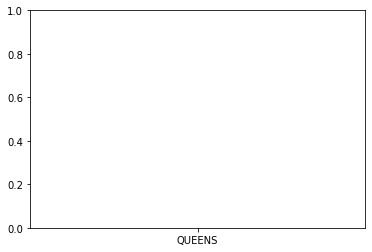

In [202]:
# Modelings
# 4. Peform clustering on the accounts of factors for airports.(Kmeans, KNN, )

# visual analysis
import matplotlib.pyplot as plt

visual_df = final_dataset_with_speed_and_airport.copy()
visual_df.avg_calculated_windspeed = visual_df.avg_calculated_windspeed*100
print(visual_df.columns)
visual_df = visual_df.drop(columns=['ref_point_lat', 'ref_point_lon', 'objectid','lat', 'lon', 'loc_id', 'region_code', 'state_name'], axis=1)
#print(visual_df)
plt.figure()
visual_df.plot(x='county',y='avg_calculated_windspeed', kind='scatter',rotation='vertical')
df_albany = visual_df[visual_df.county == 'SUFFOLK']
df_albany.plot(x='fac_name',y='avg_calculated_windspeed', kind='line')